#1- Precentacion
En este cuaderno se implementaron dos algoritmos de reescalado, siendo uno ejecutado de forma secuencial mediante CPU y otro siendo hacelerado mediante GPU

#2- Armado del ambiente

In [1]:
#@title #Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

--2021-07-04 17:37:12--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2021-07-04 17:37:12--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2021-07-04 17:37:12--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/j

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 29.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627583 sha256=9f7e5ff3e5d5e132b18dbdbf27eee4b5edd5d28675ace32d87820c6aa0c4a717
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=3210823af01820e2a5e1d92374fe9251c205b8a9eec3ee1af87ba075e2b76074
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


#3- Desarrollo

#Ejercicio 1: Reescalado de imagen por GPU

Imagen del filtro: imagen.jpg -RGB- [768, 1024]
Thread: [ 16 , 19  ], Bloque : [ 48 , 54 ]
Total de Thread: [ 768 , 1026  ]  =  787968
Tiempo TOTAL:  1418.117 [ms]
Tiempo GPU  :  1.708 [ms]


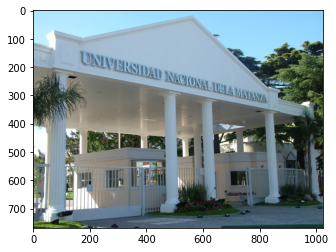

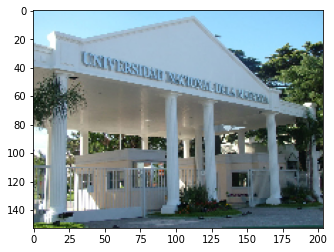

In [3]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()
import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule


# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu = numpy.empty_like( img_O_cpu)
# img_R_cpu=img_R_cpu_[0:10000 ,0:1000]


# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, float escala, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  

  if(idx < ancho && idy < alto*escala)
  {

    // Calculo el color gris para el pixel a partir de los componentes.
    int aux=int(((idx+(idy*ancho)))/escala);
    img_R[(idx+(idy*ancho))*3  ]=img_O[aux*3];
    img_R[(((idx+(idy*ancho))*3)+1 ) ]=img_O[aux*3+1 ];
    img_R[(((idx+(idy*ancho))*3)+2)  ]=img_O[aux*3+2 ];
  }


}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()
#@title ## 1 Parametros de ejecucion
#@markdown ---
#@markdown ### seleccione la escala de imagen:
escala = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), numpy.float32(escala),img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )


tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu[0:int(img_ancho*escala) ,0:int(img_alto*escala)] )
#imgplot=plt.imshow( img_R_cpu)

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

#Ejercicio 1: Reescalado de imagen por CPU

Imagen del filtro: imagen.jpg -RGB- [768, 1024]
Tiempo de conversión de imagen: 1752.085 [ms]
Tiempo Total: 1804.452 [ms]


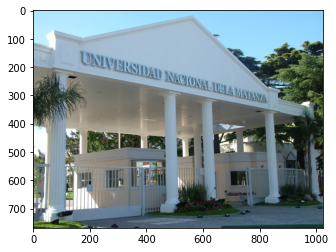

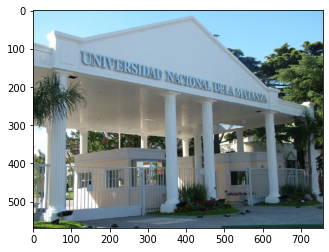

In [4]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
#@title ## 1 Parametros de ejecucion
#@markdown ---
#@markdown ### Seleccione la escala de imagen:
escala = 0.74 #@param {type:"slider", min:0, max:1, step:0.01}

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu_ = numpy.empty_like( img_pic_cpu)
img_picR_cpu=img_picR_cpu_[0:int(img_ancho * escala)+1,0:int(img_alto * escala)+1]

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

# Convierto la imagen a escala de grises
for y  in range( 0, int(img_alto) ):
  for x in range( 0, int(img_ancho) ):
    if(y < img_alto * escala and x < img_ancho * escala and y/escala < img_alto and x/escala < img_ancho):
      pixel_R, pixel_G, pixel_B = img_pic_cpu[int(x/escala)][int(y/escala)]
      img_picR_cpu[x][y] = [pixel_R, pixel_G, pixel_B]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

#4- Metricas
El algoritmo de reescalado corriendo por CPU, toma en ejecutarce en promedio 2 Seg. Corriendo acelerado por GPU roma en promedio <2ms

#5- Concluciones
En el desarrollo del trabajo pudimos notar que si bien los algorimos diceñados para correr sobre una GPU pueden ser mucho mas rapidos que los que corren sobre un CPU, son mucho mas dificiles de implementar y pueden tener imperfecciones en el resultado final

#6-Bibliografia
https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb